# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from IPython.display import display

# Data

In [3]:
loan_data = pd.read_csv('Loan_Data.csv')
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [5]:
# Analyze the data types of each column
loan_data.dtypes

customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

In [7]:
# Check for missing values in the dataset
loan_data.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

# Exploratory Data Analysis

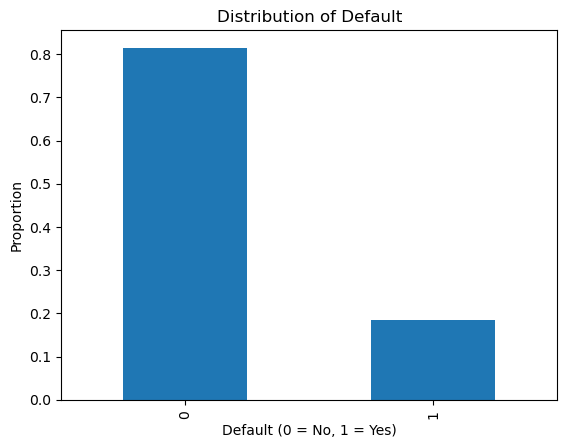

In [9]:
# Visualize the distribution of the target variable (default)
loan_data['default'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribution of Default")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Proportion")
plt.show()

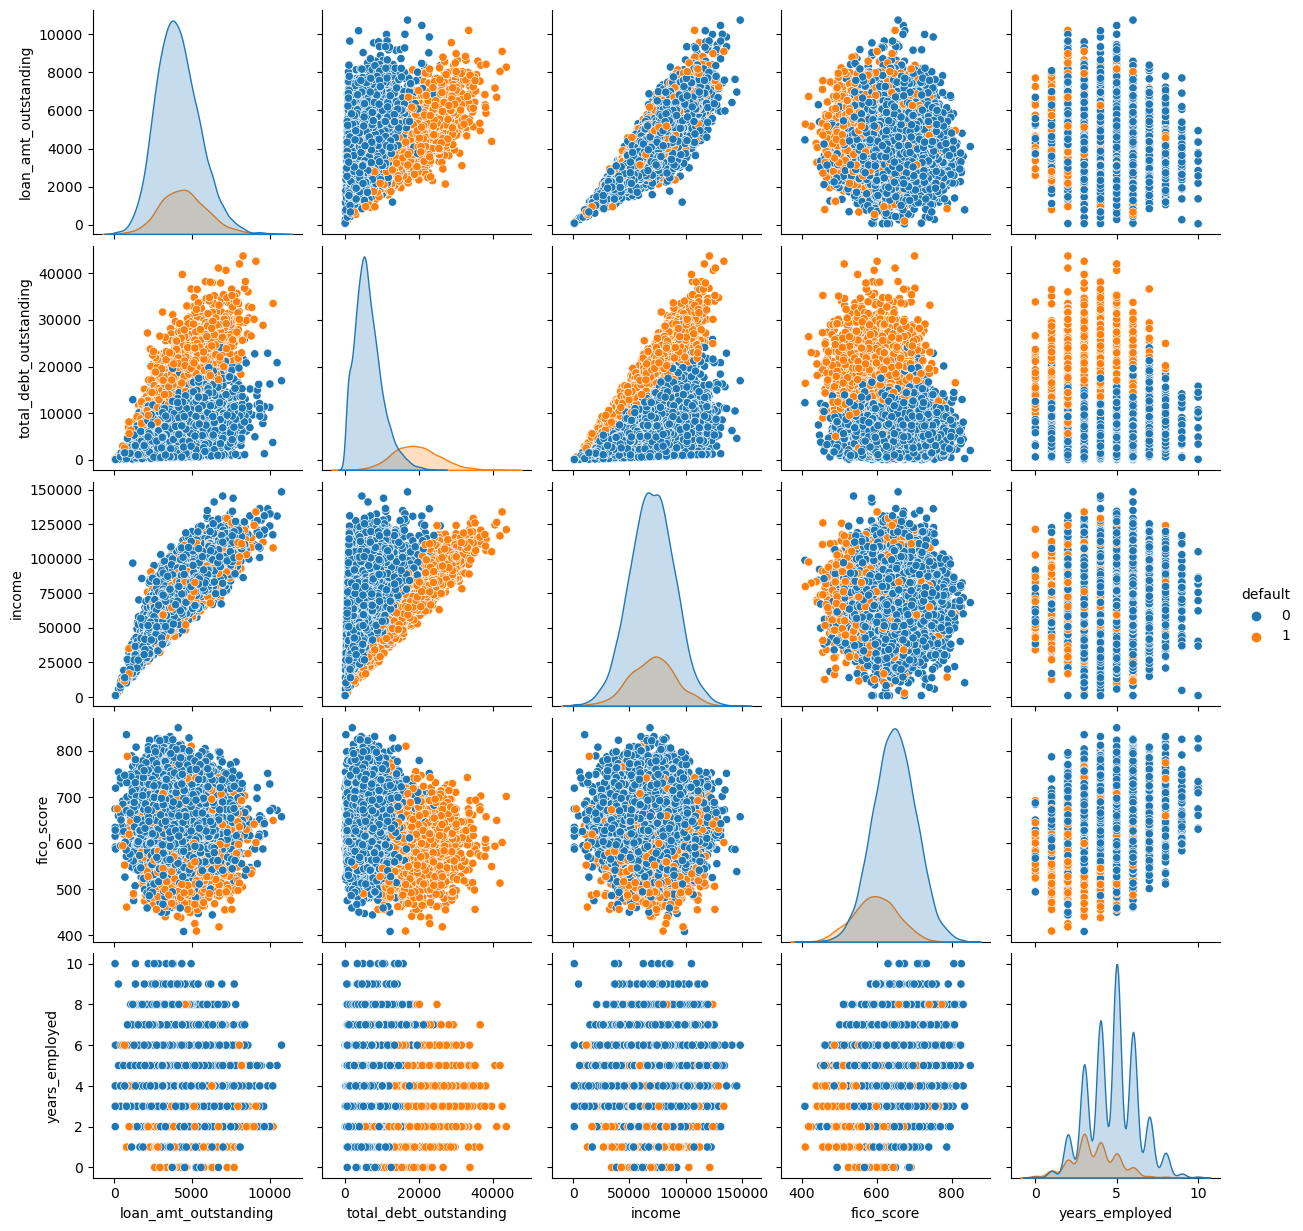

In [11]:
# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Pairplot for key numerical features against the target variable
sns.pairplot(loan_data, vars=[
    'loan_amt_outstanding', 'total_debt_outstanding', 
    'income', 'fico_score', 'years_employed'
], hue='default', diag_kind='kde')
plt.show()

In [13]:
# Check for any anomalies or non-numeric values in the numerical columns
numerical_columns = [
    'credit_lines_outstanding', 'loan_amt_outstanding', 
    'total_debt_outstanding', 'income', 
    'years_employed', 'fico_score'
]

loan_data[numerical_columns].apply(pd.to_numeric, errors='coerce').isnull().sum()

credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
dtype: int64

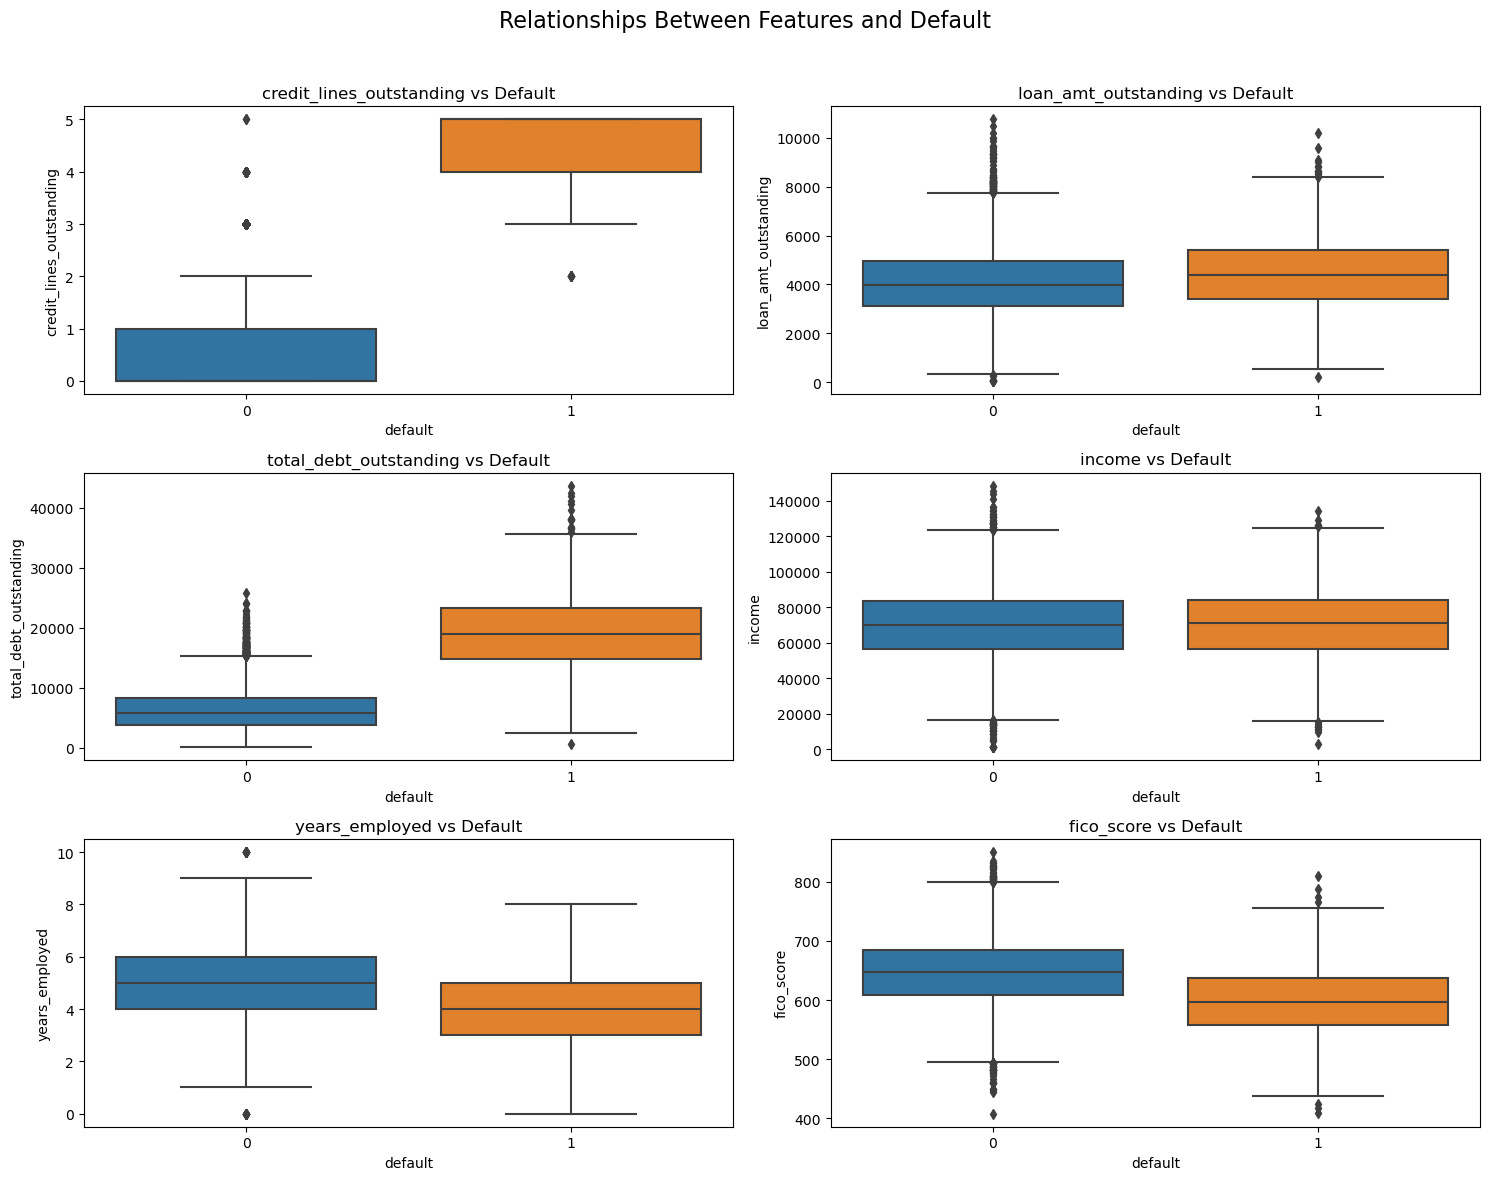

In [15]:
# Visualize the relationship of each numerical feature with the target variable (default)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Relationships Between Features and Default', fontsize=16)

features = numerical_columns
for i, feature in enumerate(features):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=loan_data, x='default', y=feature, ax=ax)
    ax.set_title(f"{feature} vs Default")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Predictive Model

In [19]:
# Define features and target variable
X = loan_data[numerical_columns]  # Features
y = loan_data['default']          # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 80% train / 20% test

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Method 1: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class (default = 1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, (y_pred_proba > 0.5).astype(int), output_dict=True)

# Method 2: Logistic Regression
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train)

# Predict probabilities for the positive class (default = 1)
log_pred_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the Logistic Regression model
log_auc = roc_auc_score(y_test, log_pred_proba)
log_report = classification_report(y_test, (log_pred_proba > 0.5).astype(int), output_dict=True)

# Method 3: Gradient Boosting (XGBoost)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', verbosity=0)
xgb_model.fit(X_train, y_train)

# Predict probabilities for the positive class (default = 1)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
xgb_report = classification_report(y_test, (xgb_pred_proba > 0.5).astype(int), output_dict=True)

# Create a DataFrame for the classification report
rf_results = pd.DataFrame(report).transpose()
log_results = pd.DataFrame(log_report).transpose()
xgb_results = pd.DataFrame(xgb_report).transpose()

# Display the results
print("=== Random Forest ===")
print(f"ROC AUC Score: {roc_auc:.4f}")
display(rf_results)

print("\n=== Logistic Regression ===")
print(f"ROC AUC Score: {log_auc:.4f}")
display(log_results)

print("\n=== XGBoost ===")
print(f"ROC AUC Score: {xgb_auc:.4f}")
display(xgb_results)

=== Random Forest ===
ROC AUC Score: 0.9999


,precision,recall,f1-score,support
0,0.996936,0.998160,0.997548,1630.000
1,0.991848,0.986486,0.989160,370.000
accuracy,0.996000,0.996000,0.996000,0.996
macro avg,0.994392,0.992323,0.993354,2000.000
weighted avg,0.995995,0.996000,0.995996,2000.000



=== Logistic Regression ===
ROC AUC Score: 1.0000


,precision,recall,f1-score,support
0,0.997552,1.000000,0.998775,1630.000
1,1.000000,0.989189,0.994565,370.000
accuracy,0.998000,0.998000,0.998000,0.998
macro avg,0.998776,0.994595,0.996670,2000.000
weighted avg,0.998005,0.998000,0.997996,2000.000



=== XGBoost ===
ROC AUC Score: 0.9999


,precision,recall,f1-score,support
0,0.996938,0.998773,0.997855,1630.0000
1,0.994550,0.986486,0.990502,370.0000
accuracy,0.996500,0.996500,0.996500,0.9965
macro avg,0.995744,0.992630,0.994178,2000.0000
weighted avg,0.996496,0.996500,0.996494,2000.0000


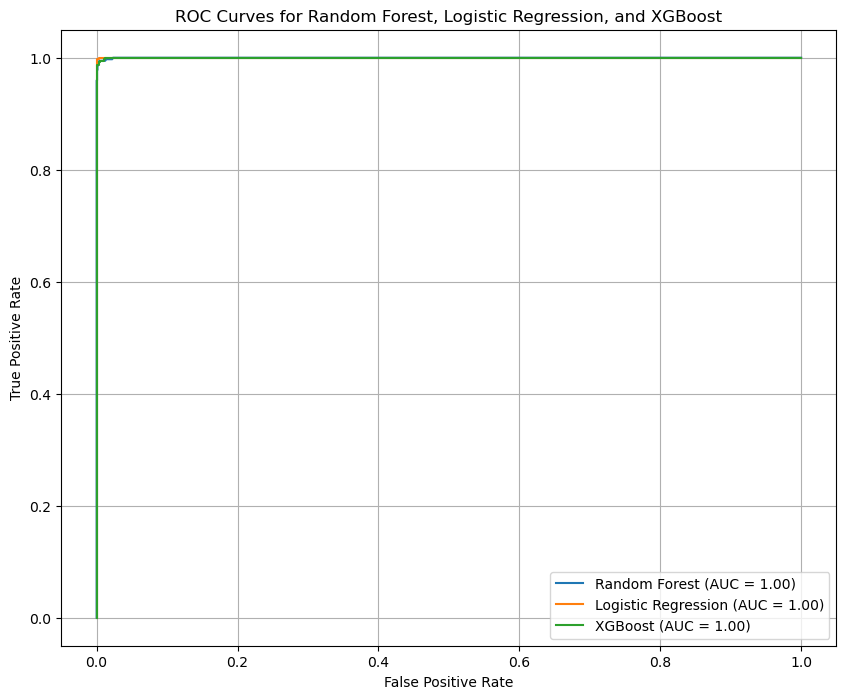

In [21]:
# Plot the ROC curves for all three models
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Random Forest ROC Curve
RocCurveDisplay.from_estimator(rf_model, X_test_scaled, y_test, name="Random Forest", ax=ax)

# Logistic Regression ROC Curve
RocCurveDisplay.from_estimator(log_model, X_test_scaled, y_test, name="Logistic Regression", ax=ax)

# XGBoost ROC Curve
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, name="XGBoost", ax=ax)

# Add titles and labels
plt.title("ROC Curves for Random Forest, Logistic Regression, and XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend(loc="lower right")
plt.show()

# Expected Loss Function

In [23]:
def calculate_expected_loss(features, model, scaler, recovery_rate=0.1):
    # Convert input dictionary to a DataFrame
    feature_df = pd.DataFrame([features])
    
    # Scale the features
    scaled_features = scaler.transform(feature_df)
    
    # Predict the Probability of Default (prob_default)
    prob_default = model.predict_proba(scaled_features)[:, 1][0]
    
    # Calculate the expected loss
    loan_amount = features['loan_amt_outstanding']
    expected_loss = prob_default * (1 - recovery_rate) * loan_amount
    
    return expected_loss

# Example usage of the function
example_borrower = {
    'credit_lines_outstanding': 2,
    'loan_amt_outstanding': 5000,
    'total_debt_outstanding': 15000,
    'income': 55000,
    'years_employed': 3,
    'fico_score': 650
}

expected_loss_rf = calculate_expected_loss(example_borrower, rf_model, scaler)
expected_loss_log = calculate_expected_loss(example_borrower, log_model, scaler)
expected_loss_xgb = calculate_expected_loss(example_borrower, xgb_model, scaler)
print(f'Random Forest : {expected_loss_rf}, Logistic Regression : {expected_loss_log}, XGBoost : {expected_loss_xgb}')

Random Forest : 1620.0, Logistic Regression : 507.6068452270809, XGBoost : 182.1159739047289


# Result Analysis

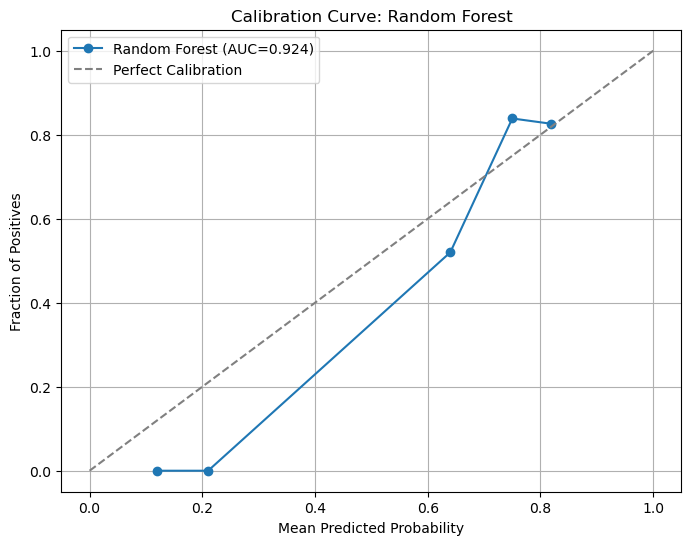

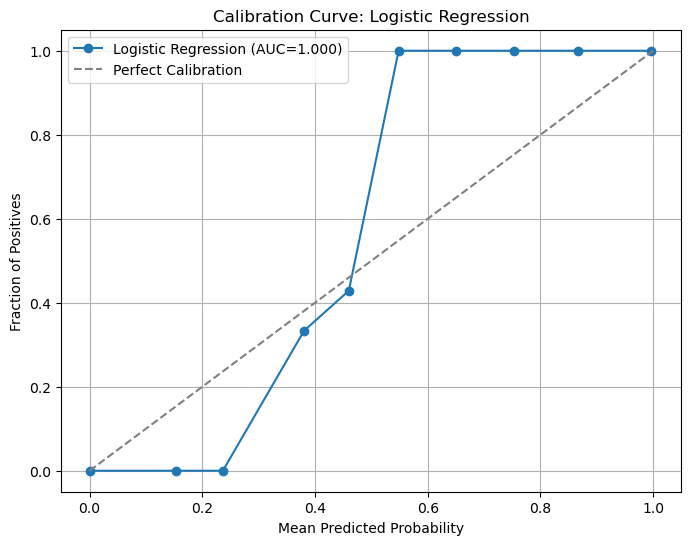

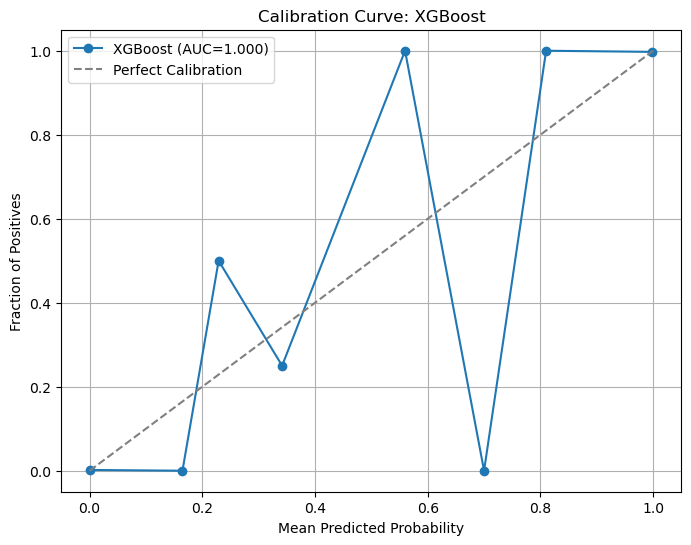

In [25]:
models = {
    'Random Forest': rf_model,
    'Logistic Regression': log_model,
    'XGBoost': xgb_model
}

scores = []

for name, model in models.items():
    if name in ['Random Forest', 'XGBoost']:
        probs = model.predict_proba(X_test.values)[:, 1]
    else:
        probs = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, probs)
    brier = brier_score_loss(y_test, probs)
    logloss = log_loss(y_test, probs)

    scores.append((name, auc, brier, logloss))

    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'{name} (AUC={auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.title(f'Calibration Curve: {name}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid()
    plt.show()

# Create a summary table of metrics for all models
metrics_table = pd.DataFrame(scores, columns=['Model', 'ROC AUC', 'Brier Score', 'Log Loss'])
metrics_table.set_index('Model', inplace=True)

In [27]:
# Display the metrics table
display(metrics_table)

,ROC AUC,Brier Score,Log Loss
Model,,,
Random Forest,0.923814,0.099589,0.341940
Logistic Regression,0.999990,0.002849,0.013121
XGBoost,0.999891,0.003015,0.010742


Logistic Regression is the best model due to its perfect discrimination (ROC AUC), superior calibration, and competitive prediction confidence. XGBoost is a close second, excelling in prediction accuracy with the lowest Log Loss.